# Fine-Tune Random Forest

## Load Libraries

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

## Utils

In [2]:
def load_data(filename):
    """
    Input: string filename
    Output: a pandas dataframe for the whole dataset after droping missing values
    Support google colab or local environments
    """
    try:
        # local environment
        df = pd.read_csv(filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df
    except:
        # google colab environment
        from google.colab import drive
        drive.mount('/content/drive')
        
        df = pd.read_csv('/content/drive/MyDrive/' + filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df

In [3]:
def split_data(df):
    """
    Input: pandas dataframe
    Output: training dataframe (81%), validation dataframe (9%), test dataframe (10%)
    """
    df_train, df_val = train_test_split(df, stratify=df['label'],test_size=0.1, random_state=42)
    
    return df_train, df_val

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        Input: string text
        Output: string cleaned text
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

## Load data

In [5]:
FILENAME = 'final_dataset_formatted.csv'
TEST_FILENAME = 'final_dataset_formatted_test.csv'

# load data
df = load_data(FILENAME)
df_test = load_data(TEST_FILENAME)

# labels
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']
num_labels = 9

# split data
df_train, df_val = split_data(df)

## Preprocess data

In [6]:
# clean text
df_train['sentence'] = df_train['sentence'].apply(clean_text)
df_val['sentence'] = df_val['sentence'].apply(clean_text)
df_test['sentence'] = df_test['sentence'].apply(clean_text)

In [7]:
# print processed sample data sentence
df_train.iloc[10, 0]

'total weight waste type disposal method'

In [8]:
# split text and labels
train_texts = df_train.iloc[:, 0]
train_labels = df_train.iloc[:, 1]
valid_texts = df_val.iloc[:, 0]
valid_labels = df_val.iloc[:, 1]
test_texts = df_test.iloc[:, 0]
test_labels = df_test.iloc[:, 1]

In [9]:
# get train, validation, and test dataset size
train_size = len(train_texts)
valid_size = len(valid_texts)
test_size = len(test_texts)

print(f'train size: {train_size}')
print(f'valid size: {valid_size}')
print(f'test size: {test_size}')

train size: 3645
valid size: 405
test size: 450


## Fine-Tune Model

In [15]:
n_estimators_list = [100, 200, 400] 
max_depth_list = [None, 10, 50, 100] 
bootstrap_list = [True, False]
min_samples_leaf_list = [1, 2, 4]
min_samples_split_list = [2, 5, 10]

best_n_estimators = 0
best_max_depth = 0
best_bootstrap = False
best_min_samples_leaf = 0
best_min_samples_split = 0

best_acc = 0
max_f1 = 0

count = 0

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for bootstrap in bootstrap_list:
            for min_samples_leaf in min_samples_leaf_list:
                for min_samples_split in min_samples_split_list:
                    
                    count += 1
                    print(count)
        
                    # build model
                    rf = Pipeline([('vect', CountVectorizer()),
                                    ('tfidf', TfidfTransformer()),
                                    ('clf', RandomForestClassifier(
                                        random_state=42, 
                                        n_estimators=n_estimators, 
                                        max_depth=max_depth, 
                                        bootstrap=bootstrap, 
                                        min_samples_leaf=min_samples_leaf, 
                                        min_samples_split=min_samples_split)),
                                   ])
                    # train model
                    rf.fit(train_texts, train_labels)

                    # generate prediction
                    y_pred = rf.predict(valid_texts)

                    # evaluate performance
                    acc = accuracy_score(valid_labels, y_pred)
                    f1 = f1_score(valid_labels, y_pred, average='macro')
            #         print(f'alpha: {alpha}, max_iter: {max_iter}:')
                    print(f'accuracy: {acc:.4f}')
                    print(f'macro_f1: {f1:.4f}')
                    print('-------------------------------')

                    # find best model (highest macro_f1 score)
                    if f1 >= max_f1:
                        best_n_estimators = n_estimators
                        best_max_depth = max_depth
                        best_bootstrap = bootstrap
                        best_min_samples_leaf = min_samples_leaf
                        best_min_samples_split = min_samples_split
                        best_acc = acc
                        max_f1 = f1

            #         print()

print(f'Best model: ')
print(f'n_estimators: {best_n_estimators}, max_depth: {max_depth}, bootstrap: {bootstrap}, min_samples_leaf: {min_samples_leaf}, min_samples_split: {min_samples_split}, acc: {best_acc}, macro_f1: {max_f1}')

1
accuracy: 0.7951
macro_f1: 0.7960
-------------------------------
2
accuracy: 0.7975
macro_f1: 0.7986
-------------------------------
3
accuracy: 0.7877
macro_f1: 0.7887
-------------------------------
4
accuracy: 0.8049
macro_f1: 0.8057
-------------------------------
5
accuracy: 0.8000
macro_f1: 0.8012
-------------------------------
6
accuracy: 0.8025
macro_f1: 0.8027
-------------------------------
7
accuracy: 0.7951
macro_f1: 0.7955
-------------------------------
8
accuracy: 0.7951
macro_f1: 0.7955
-------------------------------
9
accuracy: 0.7951
macro_f1: 0.7956
-------------------------------
10
accuracy: 0.8123
macro_f1: 0.8139
-------------------------------
11
accuracy: 0.8000
macro_f1: 0.8011
-------------------------------
12
accuracy: 0.8025
macro_f1: 0.8040
-------------------------------
13
accuracy: 0.7975
macro_f1: 0.7983
-------------------------------
14
accuracy: 0.7975
macro_f1: 0.7987
-------------------------------
15
accuracy: 0.7951
macro_f1: 0.7963
------

accuracy: 0.7901
macro_f1: 0.7916
-------------------------------
121
accuracy: 0.7802
macro_f1: 0.7808
-------------------------------
122
accuracy: 0.7827
macro_f1: 0.7836
-------------------------------
123
accuracy: 0.7901
macro_f1: 0.7910
-------------------------------
124
accuracy: 0.7827
macro_f1: 0.7833
-------------------------------
125
accuracy: 0.7827
macro_f1: 0.7833
-------------------------------
126
accuracy: 0.7877
macro_f1: 0.7882
-------------------------------
127
accuracy: 0.8025
macro_f1: 0.8036
-------------------------------
128
accuracy: 0.7926
macro_f1: 0.7933
-------------------------------
129
accuracy: 0.7926
macro_f1: 0.7932
-------------------------------
130
accuracy: 0.7951
macro_f1: 0.7956
-------------------------------
131
accuracy: 0.7951
macro_f1: 0.7956
-------------------------------
132
accuracy: 0.7951
macro_f1: 0.7956
-------------------------------
133
accuracy: 0.7926
macro_f1: 0.7929
-------------------------------
134
accuracy: 0.7926
mac

## Final Random Forest Model

In [18]:
# build model
rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(
                    random_state=42, 
                    n_estimators=best_n_estimators, 
                    max_depth=best_max_depth, 
                    bootstrap=best_bootstrap, 
                    min_samples_leaf=best_min_samples_leaf, 
                    min_samples_split=best_min_samples_split)),
               ])
# train model
rf.fit(train_texts, train_labels)

# generate prediction
y_pred = rf.predict(valid_texts)
f1 = f1_score(valid_labels, y_pred, average='macro')

# evaluate model performance
print('accuracy %s' % accuracy_score(y_pred, valid_labels))
print(f'macro_f1 score: {f1}')
print(classification_report(valid_labels, y_pred,target_names=labels))

accuracy 0.8148148148148148
macro_f1 score: 0.8154114062661441
              precision    recall  f1-score   support

          CC       0.82      0.82      0.82        45
          NC       1.00      0.80      0.89        45
          PW       0.89      0.91      0.90        45
          HC       0.75      0.73      0.74        45
          PL       0.69      0.82      0.75        45
          CR       0.81      0.76      0.78        45
          CG       0.79      0.93      0.86        45
          BE       0.82      0.73      0.78        45
           N       0.82      0.82      0.82        45

    accuracy                           0.81       405
   macro avg       0.82      0.81      0.82       405
weighted avg       0.82      0.81      0.82       405



## Final Model Test Prediction

In [19]:
# generate prediction
y_pred = rf.predict(test_texts)
f1 = f1_score(test_labels, y_pred, average='macro')

# evaluate model performance
print('accuracy %s' % accuracy_score(y_pred, test_labels))
print(f'macro_f1 score: {f1}')
print(classification_report(test_labels, y_pred,target_names=labels))

accuracy 0.8133333333333334
macro_f1 score: 0.8149933371864451
              precision    recall  f1-score   support

          CC       0.93      0.86      0.90        50
          NC       0.88      0.88      0.88        50
          PW       0.85      0.88      0.86        50
          HC       0.83      0.70      0.76        50
          PL       0.66      0.82      0.73        50
          CR       0.84      0.76      0.80        50
          CG       0.89      0.78      0.83        50
          BE       0.85      0.78      0.81        50
           N       0.68      0.86      0.76        50

    accuracy                           0.81       450
   macro avg       0.82      0.81      0.81       450
weighted avg       0.82      0.81      0.81       450



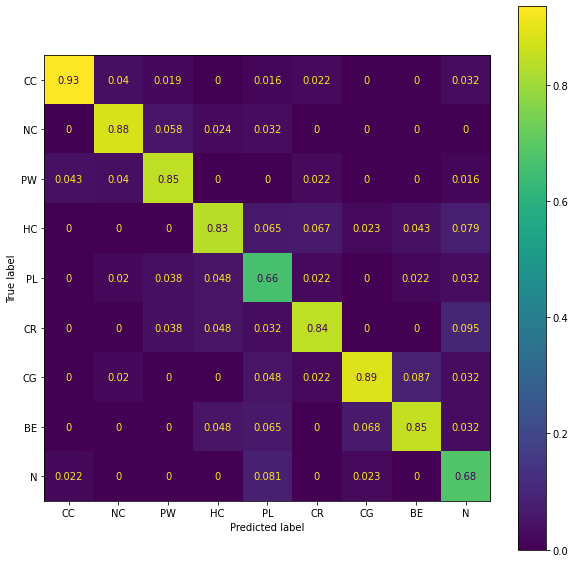

In [20]:
# plot confusion matrix
cm = confusion_matrix(test_labels, y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)